In [6]:
#Bilimsel hesaplamaları hızlı bir şekilde yapmamızı sağlayan bir matematik kütüphanesi
import numpy as np
#Veri okuma, veri ön işleme ve veri temizleme aşamalarının yapıldığı kütüphane.
import pandas as pd
#Veri görselleştirmesinde kullanılan kütüphane
import matplotlib.pyplot as plt
#Matplotlib kütüphanesine yüksek seviye arayüz sağlayan bir kütüphane
import seaborn as sns
#Python'ın string modülünü içe aktarır. Bu modül, yaygın dize işlemleri için kullanılır. 
import string
#NLTK, doğal dil işleme görevleri için kütüphane
#Stopwords:genellikle anlamsız kabul edilen ve metin analizinden çıkarılabilen yaygın stop kelimelerinin bir koleksiyonunu içerir.
#Wordcloud: metin verilerinin frekansına bağlı olarak her kelimenin boyutunun belirlendiği kelime bulutları oluşturmak için kullanılır.
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
 
# Model oluşturmak ve eğitim için gerekli olan kütüphaneler
import tensorflow as tf
#Tokenizer, metin verilerini sayılara dönüştürmek için kullanılır.
from tensorflow.keras.preprocessing.text import Tokenizer
#pad_sequences, metin dizilerini belirli bir uzunluğa kadar doldurmak veya kısaltmak için kullanılır.
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Bu fonksiyon, veri setini eğitim ve test kümelerine ayırmak için kullanılır.
from sklearn.model_selection import train_test_split
#EarlyStopping, eğitimi erken durdurmak için kullanılırken, ReduceLROnPlateau öğrenme hızını azaltmak için kullanılır.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
# import warnings
# warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ebb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
data = pd.read_csv('Emails.csv')
data.head(10)

In [150]:
#satır,sütun sayısı
data.shape

(5171, 2)

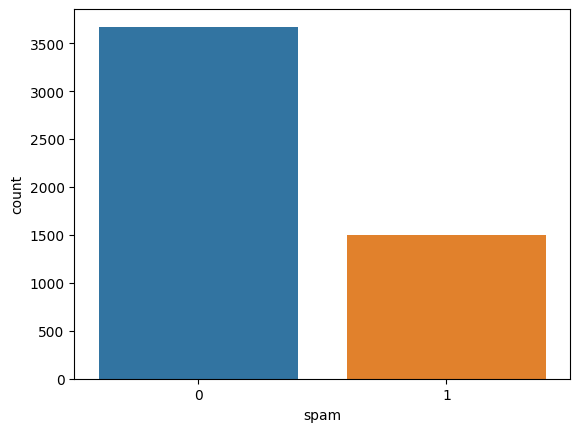

In [152]:
#target adlı sütuna göre veri görselleştirmesi yapar.
sns.countplot(x='spam', data=data)
#görselleştirme işlemi
plt.show()

<Axes: xlabel='spam', ylabel='count'>

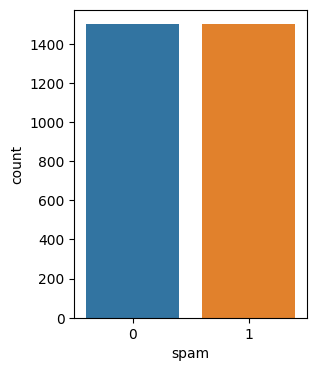

In [154]:
#Bu satırda normal ve spam mesajlar 0-1 ile eşitlenir.
normal = data[data.spam == 0]
spam = data[data.spam == 1]
#Bu satırda eşitleme yapılır.
#random_state :Modeli tekrar tekrar eğitmek veya çalıştırmak gerektiğinde sonuçların tutarlı olmasını sağlar ve sonuçların değerlendirilmesini kolaylaştırır.
normal = normal.sample(n=len(spam),
                         random_state=42)
 
#'normal' ve 'spam' veri kümelerini birleştirerek dengelenmiş bir veri kümesi oluşturur ve sınıf dağılımını görselleştirir. 
balanced_data = normal.append(spam)\
    .reset_index(drop=True)
plt.figure(figsize=(3, 4))
sns.countplot(data = balanced_data, x='spam')


In [181]:
#'balanced_data' veri kümesindeki 'text' sütunundaki metinlerde 'Subject' kelimesini kaldırarak metinleri düzenler.
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,conoco big cowboy darren sure help know else a...,0
1,feb 01 prod sale teco gas processing sale deal...,0
2,california energy crisis california  power cr...,0
3,nom actual volume april 23 rd agree eileen pon...,0
4,eastrans nomination changes effective 8 2 00 p...,0


In [182]:
#noktalama işaretlerini içeren bir liste oluşturur. Bu liste, metinlerdeki noktalama işaretlerini belirlemek için kullanılacaktır.
noktalama_listesi = string.punctuation
#Bu fonksiyon, metinden noktalama işaretlerini kaldırmak için kullanılacak.
def remove_punctuations(text):
    temp = str.maketrans('', '', noktalama_listesi)
    return text.translate(temp)
# Bu satır, 'text' sütunundaki metinlerden noktalama işaretlerini kaldırmak için remove_punctuations() fonksiyonunu uygular. 
balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,conoco big cowboy darren sure help know else a...,0
1,feb 01 prod sale teco gas processing sale deal...,0
2,california energy crisis california  power cr...,0
3,nom actual volume april 23 rd agree eileen pon...,0
4,eastrans nomination changes effective 8 2 00 p...,0


In [183]:
#Bu fonksiyon, metinden stopwords kelimelerini kaldırmak için kullanılacak.
def remove_stopwords(text):
  #stopwords.words() işlevini kullanarak İngilizce stopwords listesini yükler.
    stop_words = stopwords.words('english')
 #Bu liste, stopwords olmayan önemli kelimeleri saklamak için kullanılacak.
    imp_words = []

    for word in str(text).split():
      #Bu satır, kelimeyi küçük harfe dönüştürür ve duyarlılık kalkar.
        word = word.lower()
 #Bu satır, kelimenin stopwords listesinde olup olmadığını kontrol eder.
        if word not in stop_words:
            imp_words.append(word)
 #'imp_words' listesindeki kelimeleri boşluklarla birleştirerek tek bir metin olarak oluşturur.
    output = " ".join(imp_words)
    return output
 
 
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,conoco big cowboy darren sure help know else a...,0
1,feb 01 prod sale teco gas processing sale deal...,0
2,california energy crisis california  power cr...,0
3,nom actual volume april 23 rd agree eileen pon...,0
4,eastrans nomination changes effective 8 2 00 p...,0


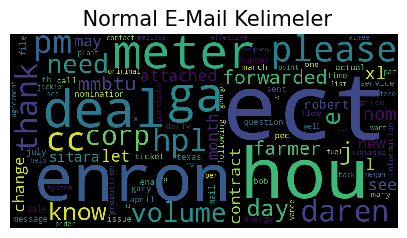

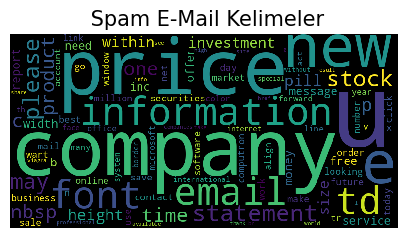

In [184]:
#Bu fonksiyon, 'balanced_data' veri kümesindeki 
#'Normal' ve 'Spam' e-posta metinlerini içeren kelime
#bulutlarını oluşturarak görselleştirmenize yardımcı olur.
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
 
    plt.figure(figsize=(5, 5))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='nearest')
    plt.title(f' {typ} E-Mail Kelimeler', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Normal')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

# Yeni Bölüm

In [185]:
#Sonuç olarak, 'balanced_data' veri kümesi,
#eğitim ve test kümelerine bölünerek train_X, test_X, train_Y ve test_Y değişkenlerine atanır.
#train_X ve test_X, metinlerin eğitim ve test verilerini içeren bağımsız değişkenlerdir, 
#train_Y ve test_Y ise eğitim ve test verilerine karşılık gelen hedef değişkenlerdir.
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [186]:
#Bu nesne, metin verilerini sayısal diziye dönüştürmek için kullanılacaktır.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
 
#Bu kod parçacığı, eğitim ve test verilerini sayısal diziye 
#dönüştürmek için Tokenizer'ı kullanır ve ardından dizileri
# aynı uzunluğa getirmek için padding işlemi uygular. 
#Böylece, metin verileri makine öğrenimi modellerinde kullanılabilecek bir sayısal formata dönüştürülür.
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
max_len = 100  
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

In [187]:

#Bu satırda, Sequential() fonksiyonu çağrılarak bir model nesnesi oluşturulur.
model = tf.keras.models.Sequential()
#Oluşturulan model, ikili sınıflandırma (spam veya normal) yapmak için tasarlanmıştır.
# Modelin özeti, katmanları ve parametre sayılarını gösterir.
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
#Modelin katmanlarını, parametre sayılarını ve çıkış şekillerini gösterir.
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 32)           1274880   
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_10 (Dense)            (None, 32)                544       
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,278,593
Trainable params: 1,278,593
Non-trainable params: 0
_________________________________________________________________


In [188]:
#Bu kod parçacığı, modelin kayıp fonksiyonu, 
#metrikler ve optimizasyon algoritması gibi derleme ayarlarını yapılandırır.
#Model derlendikten sonra, eğitim aşamasına geçmek için kullanılabilir.
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [189]:
#modelin eğitim sırasında belirli koşullara dayanarak 
#erken durmasını ve öğrenme oranını azaltmasını sağlar.
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [190]:
#modelin eğitimi yapılır ve history değişkenine atanır.
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20
75/75 [==============================] - 8s 76ms/step - loss: 0.6892 - accuracy: 0.5279 - val_loss: 0.6594 - val_accuracy: 0.5817 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 4s 57ms/step - loss: 0.2930 - accuracy: 0.9108 - val_loss: 0.2260 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 4s 59ms/step - loss: 0.1336 - accuracy: 0.9704 - val_loss: 0.2096 - val_accuracy: 0.9483 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 5s 68ms/step - loss: 0.1098 - accuracy: 0.9766 - val_loss: 0.1848 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 4s 56ms/step - loss: 0.0885 - accuracy: 0.9821 - val_loss: 0.1613 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 5s 64ms/step - loss: 0.0670 - accuracy: 0.9871 - val_loss: 0.1484 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 7/20
75/75 [==============================] - 5s 61ms/step - loss: 0.0

In [191]:

test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Veri Seti Üzerindeki Kaybı :',test_loss)
print('Test Veri Seti Üzerindeki Doğruluğu :',test_accuracy)

19/19 [==============================] - 0s 10ms/step - loss: 0.1484 - accuracy: 0.9667
Test Veri Seti Üzerindeki Kaybı : 0.14842182397842407
Test Veri Seti Üzerindeki Doğruluğu : 0.9666666388511658


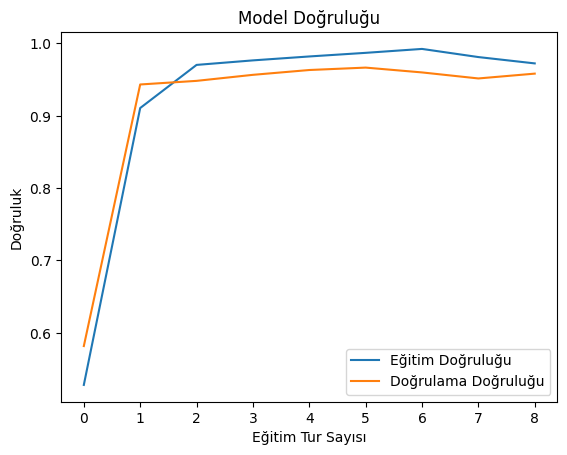

In [193]:
#Bu kod parçacığı, modelin eğitim sürecinde 
#eğitim doğruluğu ve doğrulama doğruluğunun nasıl değiştiğini görselleştirir.
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Eğitim Tur Sayısı')
plt.legend()
plt.show()